# Generate TensorRT Engines from Tensorflow (UFF models)

In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/opt/anaconda3/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


We can import TensorRT and its parsers like so:

In [2]:
import tensorrt as trt
from tensorrt.parsers import uffparser

There are also some common tools that are used with tensorrt typically. We use PyCUDA to handle the CUDA operations needed to allocate memory on your GPU and to transfer data to the GPU and results back to the CPU. We also use numpy as our primary method to store data

In [3]:
import pycuda.driver as cuda
import pycuda.autoinit
import numpy as np
from random import randint # generate a random test case
from PIL import Image
from matplotlib.pyplot import imshow #to show test case
import time
import os

In [4]:
import uff

In [5]:
STARTER_LEARNING_RATE = 1e-4
BATCH_SIZE = 10
NUM_CLASSES = 10
MAX_STEPS = 3000
IMAGE_SIZE = 28
IMAGE_PIXELS = IMAGE_SIZE ** 2
OUTPUT_NAMES = ["fc2/Relu"]

Notice that we are padding our Conv2d layer. TensorRT expects symetric padding for layers

In [7]:
def WeightsVariable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1, name='weights'))

def BiasVariable(shape):
    return tf.Variable(tf.constant(0.1, shape=shape, name='biases'))

def Conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    filter_size = W.get_shape().as_list()
    pad_size = filter_size[0]//2
    pad_mat = np.array([[0,0],[pad_size,pad_size],[pad_size,pad_size],[0,0]])
    x = tf.pad(x, pad_mat)
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def MaxPool2x2(x, k=2):
    # MaxPool2D wrapper
    pad_size = k//2
    pad_mat = np.array([[0,0],[pad_size,pad_size],[pad_size,pad_size],[0,0]])
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')

In [9]:
def network(images):
    # Convolution 1
    with tf.name_scope('conv1'):
        weights = WeightsVariable([5,5,1,32])
        biases = BiasVariable([32])
        conv1 = tf.nn.relu(Conv2d(images, weights, biases))
        pool1 = MaxPool2x2(conv1)

    # Convolution 2
    with tf.name_scope('conv2'):
        weights = WeightsVariable([5,5,32,64])
        biases = BiasVariable([64])
        conv2 = tf.nn.relu(Conv2d(pool1, weights, biases))
        pool2 = MaxPool2x2(conv2)
        pool2_flat = tf.reshape(pool2, [-1, 7 * 7 * 64])

    # Fully Connected 1
    with tf.name_scope('fc1'):
        weights = WeightsVariable([7 * 7 * 64, 1024])
        biases = BiasVariable([1024])
        fc1 = tf.nn.relu(tf.matmul(pool2_flat, weights) + biases)

    # Fully Connected 2
    with tf.name_scope('fc2'):
        weights = WeightsVariable([1024, 10])
        biases = BiasVariable([10])
        fc2 = tf.nn.relu(tf.matmul(fc1, weights) + biases)

    return fc2

In [10]:
def loss_metrics(logits, labels):
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=labels,
                                                                   logits=logits,
                                                                   name='softmax')
    return tf.reduce_mean(cross_entropy, name='softmax_mean')

In [11]:
def training(loss):
    tf.summary.scalar('loss', loss)
    global_step = tf.Variable(0, name='global_step', trainable=False)
    learning_rate = tf.train.exponential_decay(STARTER_LEARNING_RATE,
                                               global_step,
                                               100000,
                                               0.75,
                                               staircase=True)
    tf.summary.scalar('learning_rate', learning_rate)
    optimizer = tf.train.MomentumOptimizer(learning_rate, 0.9)
    train_op = optimizer.minimize(loss, global_step=global_step)
    return train_op

In [12]:
def evaluation(logits, labels):
    correct = tf.nn.in_top_k(logits, labels, 1)
    return tf.reduce_sum(tf.cast(correct, tf.int32))

In [13]:
def do_eval(sess,
            eval_correct,
            images_placeholder,
            labels_placeholder,
            data_set,
            summary):

    true_count = 0
    steps_per_epoch = data_set.num_examples // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE
    for step in range(steps_per_epoch):
        feed_dict = fill_feed_dict(data_set,
                                   images_placeholder,
                                   labels_placeholder)
        log, correctness = sess.run([summary, eval_correct], feed_dict=feed_dict)
        true_count += correctness
    precision = float(true_count) / num_examples
    tf.summary.scalar('precision', tf.constant(precision))
    print('Num examples %d, Num Correct: %d Precision @ 1: %0.04f' %
          (num_examples, true_count, precision))
    return log

In [14]:
def placeholder_inputs(batch_size):
    images_placeholder = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
    labels_placeholder = tf.placeholder(tf.int32, shape=(None))
    return images_placeholder, labels_placeholder

In [15]:
def fill_feed_dict(data_set, images_pl, labels_pl):
    images_feed, labels_feed = data_set.next_batch(BATCH_SIZE)
    feed_dict = {
        images_pl: np.reshape(images_feed, (-1,28,28,1)),
        labels_pl: labels_feed,
    }
    return feed_dict

Train and froze boi!!!

In [16]:
def run_training(data_sets):
    with tf.Graph().as_default():
        images_placeholder, labels_placeholder = placeholder_inputs(BATCH_SIZE)
        logits = network(images_placeholder)
        loss = loss_metrics(logits, labels_placeholder)
        train_op = training(loss)
        eval_correct = evaluation(logits, labels_placeholder)
        summary = tf.summary.merge_all()
        init = tf.global_variables_initializer()
        saver = tf.train.Saver()
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
        sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
        summary_writer = tf.summary.FileWriter("/tmp/tensorflow/mnist/log",
                                               graph=tf.get_default_graph())
        test_writer = tf.summary.FileWriter("/tmp/tensorflow/mnist/log/validation",
                                            graph=tf.get_default_graph())
        sess.run(init)
        for step in range(MAX_STEPS):
            start_time = time.time()
            feed_dict = fill_feed_dict(data_sets.train,
                                       images_placeholder,
                                       labels_placeholder)
            _, loss_value = sess.run([train_op, loss], feed_dict=feed_dict)
            duration = time.time() - start_time
            if step % 100 == 0:
                print('Step %d: loss = %.2f (%.3f sec)' % (step, loss_value, duration))
                summary_str = sess.run(summary, feed_dict=feed_dict)
                summary_writer.add_summary(summary_str, step)
                summary_writer.flush()
            if (step + 1) % 1000 == 0 or (step + 1) == MAX_STEPS:
                checkpoint_file = os.path.join("/tmp/tensorflow/mnist/log", "model.ckpt")
                saver.save(sess, checkpoint_file, global_step=step)
                print('Validation Data Eval:')
                log = do_eval(sess,
                              eval_correct,
                              images_placeholder,
                              labels_placeholder,
                              data_sets.validation,
                              summary)
                test_writer.add_summary(log, step)
        #return sess

        graphdef = tf.get_default_graph().as_graph_def()
        frozen_graph = tf.graph_util.convert_variables_to_constants(sess,
                                                                    graphdef,
                                                                    OUTPUT_NAMES)
        return tf.graph_util.remove_training_nodes(frozen_graph)

In [17]:
MNIST_DATASETS = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data')
tf_model = run_training(MNIST_DATASETS)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz
Step 0: loss = 8.18 (3.224 sec)
Step 100: loss = 2.34 (0.005 sec)
Step 200: loss = 2.30 (0.005 sec)
Step 300: loss = 1.96 (0.005 sec)
Step 400: loss = 2.22 (0.005 sec)
Step 500: loss = 1.88 (0.006 sec)
Step 600: loss = 2.10 (0.005 sec)
Step 700: loss = 2.31 (0.005 sec)
Step 800: loss = 1.64 (0.005 sec)
Step 900: loss = 2.00 (0.005 sec)
Validation Data Eval:
Num examples 5000, Num Correct: 4567 Precision @ 1: 0.9134
Step 1000: loss = 2.05 (0.009 sec)
Step 11

In [18]:
uff_model = uff.from_tensorflow(tf_model, ["fc2/Relu"])

Using output node fc2/Relu
Converting to UFF graph
No. nodes: 28


In [19]:
G_LOGGER = trt.infer.ConsoleLogger(trt.infer.LogSeverity.ERROR)

In [20]:
parser = uffparser.create_uff_parser()
parser.register_input("Placeholder", (1,28,28), 0)
parser.register_output("fc2/Relu")

True

In [21]:
engine = trt.utils.uff_to_trt_engine(G_LOGGER, uff_model, parser, 1, 1 << 20)

In [22]:
parser.destroy()

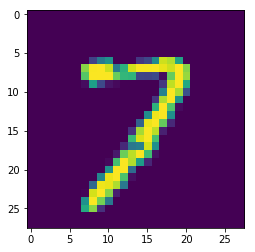

In [23]:
img, label = MNIST_DATASETS.test.next_batch(1)
img = img[0]
#convert input data to Float32
img = img.astype(np.float32)
label = label[0]
%matplotlib inline
imshow(img.reshape(28,28))

In [24]:
runtime = trt.infer.create_infer_runtime(G_LOGGER)
context = engine.create_execution_context()

In [25]:
output = np.empty(10, dtype = np.float32)

#alocate device memory
d_input = cuda.mem_alloc(1 * img.size * img.dtype.itemsize)
d_output = cuda.mem_alloc(1 * output.size * output.dtype.itemsize)

In [26]:
bindings = [int(d_input), int(d_output)]

In [27]:
stream = cuda.Stream()

In [29]:
#transfer input data to device
cuda.memcpy_htod_async(d_input, img, stream)
#execute model
context.enqueue(1, bindings, stream.handle, None)
#transfer predictions back
cuda.memcpy_dtoh_async(output, d_output, stream)
#syncronize threads
stream.synchronize()

In [30]:
print("Test Case: " + str(label))
print ("Prediction: " + str(np.argmax(output)))

Test Case: 7
Prediction: 0


In [31]:
trt.utils.write_engine_to_file("./tf_mnist.engine", engine.serialize())

True

In [32]:
new_engine = trt.utils.load_engine(G_LOGGER, "./tf_mnist.engine")

In [33]:
context.destroy()
engine.destroy()
new_engine.destroy()
runtime.destroy()